# P_bar globe, based on P_bar deep dive

Need to try this coord interp again, but with the methods that seem promising from P_bar deep dive

## Housekeeping

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from tqdm.notebook import tqdm
from scipy.ndimage import uniform_filter1d

In [2]:
import os
os.chdir('/home/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [3]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load pre-made datasets

In [8]:
#individual profiles where sampling rate <=2.5m, pressure grid
ds_p = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_p.nc').rename({'PRES_INTERPOLATED':'PRESSURE','N_PROF':'PROFILE','LATITUDE':'LAT','LONGITUDE':'LON'})   
ds_p


<xarray.Dataset> Size: 95GB
Dimensions:          (PROFILE: 1488063, PRESSURE: 1001)
Coordinates:
  * PRESSURE         (PRESSURE) int64 8kB 0 2 4 6 8 ... 1992 1994 1996 1998 2000
    TIME             (PROFILE) datetime64[ns] 12MB ...
    LAT              (PROFILE) float64 12MB ...
    LON              (PROFILE) float64 12MB ...
  * PROFILE          (PROFILE) int64 12MB 2428701 1114461 ... 1502504 411205
Data variables:
    CT               (PROFILE, PRESSURE) float64 12GB ...
    CYCLE_NUMBER     (PROFILE, PRESSURE) float64 12GB ...
    PLATFORM_NUMBER  (PROFILE, PRESSURE) float64 12GB ...
    PRES             (PROFILE, PRESSURE) float32 6GB ...
    PSAL             (PROFILE, PRESSURE) float32 6GB ...
    SA               (PROFILE, PRESSURE) float64 12GB ...
    SIG0             (PROFILE, PRESSURE) float64 12GB ...
    TEMP             (PROFILE, PRESSURE) float32 6GB ...
    sample_rate      (PROFILE, PRESSURE) float32 6GB ...
    SPICE            (PROFILE, PRESSURE) float64 12GB ...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [4]:
RG_p = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_p_grid3.nc').rename({'lat':'LAT','lon':'LON','pressure':'PRESSURE'})
RG_p

<xarray.Dataset> Size: 177MB
Dimensions:   (PRESSURE: 1001, LAT: 61, LON: 121)
Coordinates:
  * LAT       (LAT) int64 488B -90 -87 -84 -81 -78 -75 -72 ... 75 78 81 84 87 90
  * LON       (LON) int64 968B -180 -177 -174 -171 -168 ... 168 171 174 177 180
  * PRESSURE  (PRESSURE) int64 8kB 0 2 4 6 8 10 ... 1992 1994 1996 1998 2000
Data variables:
    CT        (PRESSURE, LAT, LON) float64 59MB ...
    SA        (PRESSURE, LAT, LON) float64 59MB ...
    SIG0      (PRESSURE, LAT, LON) float64 59MB ...

## Sort by density and reindex (individual profiles)

In [5]:
def sorting_index_from_sig(sig):
    """
    sig0: 1D numpy array for a single profile.
    Returns: 1D array of indices (same length) that sorts the valid region
             and leaves NaNs at the edges.
    """
    valid = ~np.isnan(sig)

    if not np.any(valid):
        return np.arange(len(sig))  # nothing to sort

    # valid region boundaries
    i0 = np.argmax(valid)
    i1 = len(sig) - np.argmax(valid[::-1])

    # sorting index for the core region
    core = sig[i0:i1]
    core_sort_idx = np.argsort(core)

    # build full index array
    full_idx = np.arange(len(sig))
    full_idx[i0:i1] = full_idx[i0:i1][core_sort_idx]

    return full_idx

In [6]:
def apply_sort_index(var, sort_idx, dim="PRESSURE"):
    return xr.apply_ufunc(
        lambda v, idx: v[idx],
        var,
        sort_idx,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[dim]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[var.dtype],
    )

In [9]:
ds_sort_idx = xr.apply_ufunc(
    sorting_index_from_sig,
    ds_p["SIG0"],
    input_core_dims=[["PRESSURE"]],
    output_core_dims=[["PRESSURE"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int],
)

In [10]:
ds_p["SIG0_sort"] = apply_sort_index(ds_p["SIG0"], ds_sort_idx)

In [51]:
#vars_to_sort = ["CT", "SA", "TEMP", "PSAL", "PRESSURE", "SPICE"]

vars_to_sort = ["CT", "SA", "SPICE"]

for v in vars_to_sort:
    ds_p[f"{v}_sort"] = apply_sort_index(ds_p[v], ds_sort_idx)

In [12]:
#plots to compare CT to CT_sort on the globe

## Sort by density (climatology)

In [13]:
RG_sort_idx = xr.apply_ufunc(
    sorting_index_from_sig,
    RG_p["SIG0"],
    input_core_dims=[["PRESSURE"]],
    output_core_dims=[["PRESSURE"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int],
)

In [14]:
RG_p["SIG0_sort"] = apply_sort_index(RG_p["SIG0"], RG_sort_idx)

In [15]:
vars_to_sort = ["CT", "SA"]

for v in vars_to_sort:
    RG_p[f"{v}_sort"] = apply_sort_index(RG_p[v], RG_sort_idx)

## Create ds_r

In [52]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [53]:
def get_ds_rho(ds_z, da_SIG, rho_grid, variables, dim1='PROFILE', dim2='PRESSURE', RG_flag=False):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1, 'rho_grid'],
            coords={'rho_grid': rho_grid, dim1: ds_z[dim1]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')

    if RG_flag==False:
        ds_rho = ds_rho.assign_coords(LAT  =(dim1, ds_z.LAT.data))
        ds_rho = ds_rho.assign_coords(LON  =(dim1, ds_z.LON.data))
        ds_rho = ds_rho.assign_coords(TIME =(dim1, ds_z.TIME.data))
    
    return ds_rho

In [54]:
#again just doing CT for now, to see where we're at for method validation
variables = ['CT_sort','SA_sort','SPICE_sort','PRESSURE']
ds_r = get_ds_rho(ds_p, ds_p.SIG0_sort, np.arange(22,28,0.001), variables)

Completed comp for CT_sort
Completed CT_sort


KeyboardInterrupt: 

In [ ]:
ds_r = ds_r.rename({'rho_grid':'DENSITY'})

#### Need to convert RG_p to RG_r to preserve sorting, requires stacking and unstacking

In [74]:
RG_p_stacked = RG_p.stack(PROFILE=("LAT", "LON"))

pressure = RG_p_stacked.PRESSURE.data  # shape (1001,)
prof = RG_p_stacked.PROFILE.size      # number of profiles

# Repeat pressure along columns to get shape (1001, prof)
pressure_2d = np.repeat(pressure[:, np.newaxis], prof, axis=1)

# Add as a new variable with fresh name to avoid conflict
RG_p_stacked["PRESSURE"] = (("PRESSURE", "PROFILE"), pressure_2d)

In [75]:
RG_r_stacked = get_ds_rho(RG_p_stacked, RG_p_stacked.SIG0_sort, np.arange(22,28,0.001), ['CT_sort','SA_sort','SIG0_sort','PRESSURE'], RG_flag=True)

Completed comp for CT_sort
Completed CT_sort
Completed comp for SA_sort
Completed SA_sort
Completed comp for SIG0_sort
Completed SIG0_sort


/home/amf2288/miniconda3/envs/Argo_old_xgcm/lib/python3.11/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


Completed comp for PRESSURE
Completed PRESSURE
Completed merge


In [76]:
RG_r = RG_r_stacked.unstack('PROFILE').rename({'rho_grid':'DENSITY'})
RG_r

<xarray.Dataset> Size: 1GB
Dimensions:    (LAT: 61, LON: 121, DENSITY: 6000)
Coordinates:
  * LAT        (LAT) int64 488B -90 -87 -84 -81 -78 -75 ... 75 78 81 84 87 90
  * LON        (LON) int64 968B -180 -177 -174 -171 -168 ... 168 171 174 177 180
  * DENSITY    (DENSITY) float64 48kB 22.0 22.0 22.0 22.0 ... 28.0 28.0 28.0
Data variables:
    CT_sort    (DENSITY, LAT, LON) float64 354MB nan nan nan nan ... nan nan nan
    SA_sort    (DENSITY, LAT, LON) float64 354MB nan nan nan nan ... nan nan nan
    SIG0_sort  (DENSITY, LAT, LON) float64 354MB nan nan nan nan ... nan nan nan
    PRESSURE   (DENSITY, LAT, LON) int64 354MB -9223372036854775808 ... -9223...

/home/amf2288/miniconda3/envs/Argo_old_xgcm/lib/python3.11/site-packages/xarray/plot/utils.py:245: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


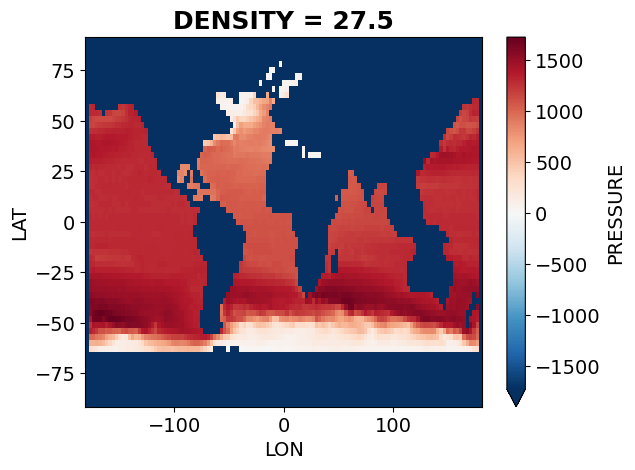

In [81]:
RG_r.PRESSURE.sel(DENSITY=27.5,method='nearest').plot(x='LON',y='LAT')

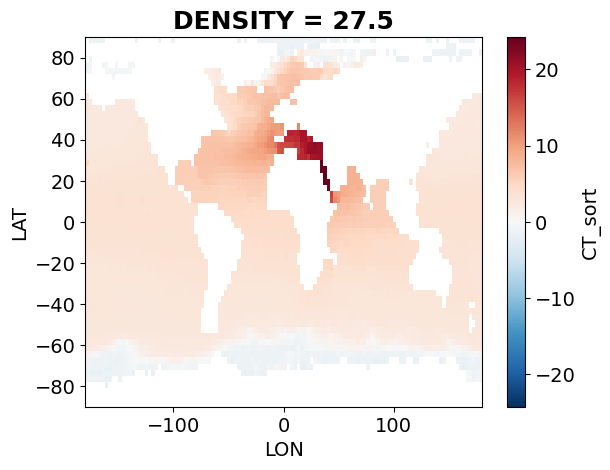

In [80]:
ds_r_grid.CT_sort.sel(DENSITY=27.5,method='nearest').plot(x='LON',y='LAT')

## Match climatology to profiles

In [25]:
def match_mean_profiles(ds_r, pres_rho_gridded, lon_bins, lat_bins):
    # Bin indices
    lat_idx = np.digitize(ds_r.LAT.values, lat_bins) - 1
    lon_idx = np.digitize(ds_r.LON.values, lon_bins) - 1

    # Validate indices
    valid = (
        (lat_idx >= 0) & (lat_idx < pres_rho_gridded.sizes['LAT']) &
        (lon_idx >= 0) & (lon_idx < pres_rho_gridded.sizes['LON'])
    )

    # Transpose to match original indexing: [density, lon, lat]
    pres_grid = pres_rho_gridded.transpose('DENSITY', 'LON', 'LAT').values

    # Initialize output
    matched_profiles = np.full(
        (ds_r.sizes['PROFILE'], ds_r.sizes['DENSITY']),
        np.nan,
        dtype=np.float32
    )

    # Loop with progress bar
    for i in tqdm(range(ds_r.sizes['PROFILE']), desc="Matching profiles", unit="PROFILE"):
        if valid[i]:
            try:
                matched_profiles[i, :] = pres_grid[:, lon_idx[i], lat_idx[i]]
            except IndexError:
                continue

    # Return as DataArray
    return xr.DataArray(
        matched_profiles,
        dims=('PROFILE', 'DENSITY'),
        coords={'PROFILE': ds_r.PROFILE, 'DENSITY': ds_r.DENSITY}
    )

In [26]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-90,91,3)

In [27]:
ds_r['PRESSURE_mean'] = match_mean_profiles(ds_r, RG_r.PRESSURE, lon_bins, lat_bins)

Matching profiles:   0%|          | 0/1488063 [00:00<?, ?PROFILE/s]

In [28]:
ds_r

<xarray.Dataset> Size: 179GB
Dimensions:        (DENSITY: 6000, PROFILE: 1488063)
Coordinates:
  * DENSITY        (DENSITY) float64 48kB 22.0 22.0 22.0 22.0 ... 28.0 28.0 28.0
  * PROFILE        (PROFILE) int64 12MB 2428701 1114461 ... 1502504 411205
    LAT            (PROFILE) float64 12MB -78.16 -78.15 -78.15 ... 89.77 89.78
    LON            (PROFILE) float64 12MB -174.6 -161.6 -175.1 ... -99.35 139.1
    TIME           (PROFILE) datetime64[ns] 12MB 2024-01-31T06:16:20 ... 2011...
Data variables:
    CT_sort        (PROFILE, DENSITY) float64 71GB nan nan nan ... nan nan nan
    PRESSURE       (PROFILE, DENSITY) int64 71GB -9223372036854775808 ... -92...
    PRESSURE_mean  (PROFILE, DENSITY) float32 36GB -9.223e+18 ... -9.223e+18

## Create ds_pbar

In [29]:
def make_progress_wrapper(base_func, total, desc):
    bar = tqdm(total=total, desc=desc, unit="profile")

    def wrapped(var_profile, pres_mean, pmean_grid):
        result = base_func(var_profile, pres_mean, pmean_grid)
        bar.update(1)
        return result

    return wrapped

In [30]:
def interp_to_pmean(var_profile, pres_mean, pmean_grid):

    try:
        pmean_smooth = pres_mean
        
        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        return np.full_like(pmean_grid, np.nan)
        print(f"ValueError")

In [31]:
def get_ds_pmean(ds_r, pmean_grid, variables, dim1='PROFILE', dim_dens='DENSITY', dim_pmean='PRESSURE_bar'):
    
    xrs = []
    pmean_size = pmean_grid.size
    n_profiles = ds_r.sizes[dim1]
    
    for var in variables:
        print(f"Starting interpolation for {var}")
        wrapped_interp = make_progress_wrapper(interp_to_pmean, total=n_profiles, desc=f"{var}")

        var_interp = xr.apply_ufunc(
            wrapped_interp, ds_r[var], ds_r['PRESSURE_mean'],
            input_core_dims=[[dim_dens], [dim_dens]],
            output_core_dims=[[dim_pmean]],
            dask_gufunc_kwargs={'output_sizes': {dim_pmean: pmean_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'pmean_grid': pmean_grid},
            output_dtypes=[ds_r[var].dtype]
        )

        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1, dim_pmean],
            coords={dim_pmean: pmean_grid, dim1: ds_r[dim1]},
            name=var
        )
        xrs.append(var_interp)
        print(f"Completed {var}")

    ds_pmean = xr.merge(xrs)
    ds_pmean = ds_pmean.assign_coords(lat=(dim1, ds_r.LAT.data))
    ds_pmean = ds_pmean.assign_coords(lon=(dim1, ds_r.LON.data))
    
    return ds_pmean

In [32]:
ds_pbar = get_ds_pmean(ds_r, np.linspace(0, 2000, 1001), ['CT_sort'])

Starting interpolation for CT_sort


Starting interpolation for CT_sort


CT_sort:   0%|          | 0/1488063 [00:00<?, ?profile/s]

Starting interpolation for CT_sort


CT_sort:   0%|          | 0/1488063 [00:00<?, ?profile/s]

Completed CT_sort


## Create gridded ds_p, ds_r, ds_pbar

In [31]:
#ds_p.to_netcdf('/swot/SUM05/amf2288/ds_p_current.nc')
#ds_r.to_netcdf('/swot/SUM05/amf2288/ds_r_current.nc')
#ds_pbar.to_netcdf('/swot/SUM05/amf2288/ds_pbar_current.nc')
#ds_p_grid.to_netcdf('/swot/SUM05/amf2288/ds_p_grid_current.nc')
#ds_r_grid.to_netcdf('/swot/SUM05/amf2288/ds_r_grid_current.nc')
#ds_pbar_grid.to_netcdf('/swot/SUM05/amf2288/ds_pbar_grid_current.nc')

In [32]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/ds_p_current.nc')
ds_r = xr.open_dataset('/swot/SUM05/amf2288/ds_r_current.nc')
ds_pbar = xr.open_dataset('/swot/SUM05/amf2288/ds_pbar_current.nc').rename({'lat':'LAT','lon':'LON'})

ds_p_grid = xr.open_dataset('/swot/SUM05/amf2288/ds_p_grid_current.nc')
ds_r_grid = xr.open_dataset('/swot/SUM05/amf2288/ds_r_grid_current.nc')
ds_pbar_grid = xr.open_dataset('/swot/SUM05/amf2288/ds_pbar_grid_current.nc')

In [28]:
def get_ds_gridded(ds, lon_bins, lat_bins, z_coord):
    pbar = tqdm(total=4, desc="Gridding dataset", unit="step")
    
    # Step 1: Reduce using flox
    ds_binned = xarray_reduce(
        ds,
        'LON',
        'LAT',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True
    )
    pbar.update(1)

    # Step 2: Rename dimensions and variables
    ds_binned = ds_binned.rename_dims({
        'LON_bins': 'LON',
        'LAT_bins': 'LAT',}).rename_vars({
        #'rho_grid': 'density'
        'LON_bins': 'LON',
        'LAT_bins': 'LAT',
        #'rho_grid': 'density'
    })
    pbar.update(1)

    # Step 3: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'LON': ('LON', interval_midpoints(ds_binned['LON'].values)),
        'LAT': ('LAT', interval_midpoints(ds_binned['LAT'].values))
    })
    pbar.update(1)

    # Step 4: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'LON', 'Y': 'LAT'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'LON', 'left': 'LON_left'},
        'Y': {'center': 'LAT', 'left': 'LAT_left'},
        'Z': {'center': z_coord}
    }, periodic=['X'])
    pbar.update(1)
    
    pbar.close()

    return ds_gridded, grid

In [29]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-90,91,3)

In [30]:
#ds_p_grid, grid = get_ds_gridded(ds_p, lon_bins, lat_bins, 'PRESSURE')
#print('Completed gridding ds_p')
#ds_r_grid, grid = get_ds_gridded(ds_r, lon_bins, lat_bins, 'DENSITY')
#print('Completed gridding ds_r')
ds_pbar_grid, grid = get_ds_gridded(ds_pbar, lon_bins, lat_bins, 'PRESSURE_bar')
print('Completed gridding ds_pbar')

Gridding dataset:   0%|          | 0/4 [00:00<?, ?step/s]

Completed gridding ds_pbar


## Plots: comparison to box

In [34]:
#repeat plots from p_bar_deep_dive notebook
section_p = ds_p.where((ds_p.LAT < -25) & (ds_p.LAT > -35),drop=True).where((ds_p.LON < -138) & (ds_p.LON > -140),drop=True).sortby('LAT')
section_r = ds_r.where((ds_r.LAT < -25) & (ds_r.LAT > -35),drop=True).where((ds_r.LON < -138) & (ds_r.LON > -140),drop=True).sortby('LAT')
section_pbar = ds_pbar.where((ds_pbar.LAT < -25) & (ds_pbar.LAT > -35),drop=True).where((ds_pbar.LON < -138) & (ds_pbar.LON > -140),drop=True).sortby('LAT')

In [35]:
#only keep profiles with at least n data points
ct_counts = section_p['CT_sort'].count(dim='PRESSURE')
profiles_to_keep = ct_counts >= 500

section_p = section_p.sel(PROFILE=profiles_to_keep).sortby('LAT')
section_r = section_r.sel(PROFILE=profiles_to_keep).sortby('LAT')
section_pbar = section_pbar.sel(PROFILE=profiles_to_keep).sortby('LAT')

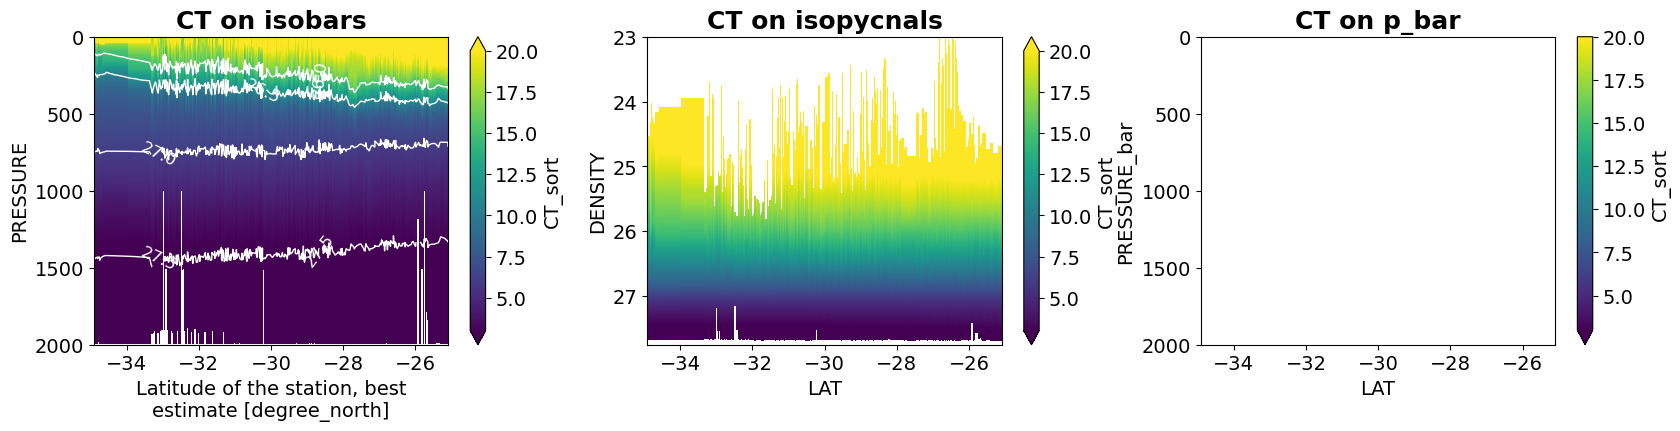

In [71]:
plt.figure(figsize=(20,4))
levels = [26,26.5,27,27.5]
x = 'LAT'

plt.subplot(131)
section_p.CT_sort.plot(x=x,y='PRESSURE',vmin=3,vmax=20)
X, Y = np.meshgrid(section_p.LAT.values, section_p.PRESSURE.values)
contours1 = plt.contour(X, Y, section_p.SIG0_sort.values.T, levels=levels, colors='white', linewidths=1)
plt.clabel(contours1, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
#plt.ylim(1800,100)
plt.title('CT on isobars')

plt.subplot(132)
section_r.CT_sort.plot(x=x, y='DENSITY',vmin=3,vmax=20)
#X, Y = np.meshgrid(section_r.LAT.values, section_r.DENSITY.values)
#contours2 = plt.contour(X, Y, section_r.SIG0_sort.values.T, levels=levels, colors='white', linewidths=1)
#plt.clabel(contours2, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.ylim(27.75,23)
plt.title('CT on isopycnals')

plt.subplot(133)
section_pbar.CT_sort.plot(x=x, y='PRESSURE_bar',vmin=3,vmax=20)
#X, Y = np.meshgrid(section_pbar.LAT.values, section_pbar.PRESSURE_bar.values)
#contours3 = plt.contour(X, Y, section_pbar.SIG0_sort.values.T, levels=levels, colors='white', linewidths=1)
#plt.clabel(contours3, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
#plt.ylim(1800,100)
plt.title('CT on p_bar')

plt.subplots_adjust(wspace=0.25)

## Plots: global

In [ ]:
#global maps, 100m
plt.figure(figsize=(15, 10))
depth1, vmin1, vmax1 =   10, 10, 25
depth2, vmin2, vmax2 =  100, 10, 25
depth3, vmin3, vmax3 = 1000,  3, 10
depth4, vmin4, vmax4 = 1800,  0,  5

plt.subplots(4,2,1)
ds_p_grid.CT_sort.sel(PRESSURE=depth1, method='nearest').plot(cmap=cmo.thermal, vmin=vmin1, vmax=vmax1)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on isobars at {depth1}m')

plt.subplots(4,2,2)
ds_pbar_grid.CT_sort.sel(PRESSURE_bar=depth1, method='nearest').plot(cmap=cmo.thermal, vmin=vmin1, vmax=vmax1)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on p_bar at {depth1}m')

plt.subplots(4,2,3)
ds_p_grid.CT_sort.sel(PRESSURE=depth2, method='nearest').plot(cmap=cmo.thermal, vmin=vmin2, vmax=vmax2)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on isobars at {depth2}m')

plt.subplots(4,2,4)
ds_pbar_grid.CT_sort.sel(PRESSURE_bar=depth2, method='nearest').plot(cmap=cmo.thermal, vmin=vmin2, vmax=vmax2)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on p_bar at {depth2}m')

plt.subplots(4,2,5)
ds_p_grid.CT_sort.sel(PRESSURE=depth3, method='nearest').plot(cmap=cmo.thermal, vmin=vmin3, vmax=vmax3)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on isobars at {depth3}m')

plt.subplots(4,2,6)
ds_pbar_grid.CT_sort.sel(PRESSURE_bar=depth3, method='nearest').plot(cmap=cmo.thermal, vmin=vmin3, vmax=vmax3)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on p_bar at {depth3}m')

plt.subplots(4,2,7)
ds_p_grid.CT_sort.sel(PRESSURE=depth4, method='nearest').plot(cmap=cmo.thermal, vmin=vmin4, vmax=vmax4)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on isobars at {depth4}m')

plt.subplots(4,2,8)
ds_pbar_grid.CT_sort.sel(PRESSURE_bar=depth4, method='nearest').plot(cmap=cmo.thermal, vmin=vmin4, vmax=vmax4)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on p_bar at {depth4}m')